In [9]:
user_net_id = 'aks9136'

In [10]:
import sys
sys.path.append('/scratch/' + user_net_id + '/NYU-Zillow-Capstone-2022-Team-A')

import os
import random
import math
import json
import yaml

import torch
import pydantic
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from PIL import Image
import hydra
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import dgl

from src.datamodules.mscoco import MSCOCODataset

In [11]:
# conf
root = '/scratch/' + user_net_id + '/NYU-Zillow-Capstone-2022-Team-A/'+ "coco"
partition = "val2017"
batch_size = 100
num_workers = 8

vision_model = "ViT-B/32"
model_id = "openai/clip-vit-base-patch32"

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

In [14]:
ds = MSCOCODataset(
        root=root,
        annFile=os.path.join(root, "annotations", f"instances_{partition}.json")
        #transform=preprocess
    )

ann_items = ds.coco.loadCats(ds.coco.getCatIds())
tags = [item['name'] for item in ann_items]
tag_ids = [item['id'] for item in ann_items]

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


In [15]:
print(tag_ids)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]


In [17]:
images_tensor = None
tags_tensor = None

with torch.no_grad():
    for i in tqdm(range(0, len(ds.ids), batch_size), desc='encoding image batches'):
        batch_ids = ds.ids[i:i+batch_size]
        batch_imgs = [Image.open(root + '/images/'+ds.coco.loadImgs(id)[0]["file_name"]).convert('RGB') for id in batch_ids]
        batch = processor(
                    text=None,
                    images=batch_imgs,
                    return_tensors='pt',
                    padding=True
                )['pixel_values'].to(device)
        batch_emb = model.get_image_features(pixel_values=batch)
        batch_emb = batch_emb.squeeze(0)
        
        if images_tensor is None:
            images_tensor = batch_emb
        else:
            images_tensor = torch.cat((images_tensor, batch_emb), dim=0)

    for tag in tqdm(tags, desc='encoding tags'):
        inputs = tokenizer(tag, return_tensors="pt")
        tag_emb = model.get_text_features(**inputs)

        if tags_tensor is None:
            tags_tensor = tag_emb
        else:
            tags_tensor = torch.cat((tags_tensor, tag_emb), dim=0)
        

encoding tags: 100%|██████████| 80/80 [00:00<00:00, 110.75it/s]


In [18]:
print(images_tensor.shape)
print(tags_tensor.shape)
print(images_tensor[0][:10])
print(tags_tensor[0][:10])

torch.Size([5000, 512])
torch.Size([80, 512])
tensor([-0.0724, -0.0059, -0.3013,  0.0826,  0.2546, -0.2976,  0.2935,  0.0293,
        -0.0527,  0.0108])
tensor([ 0.1695,  0.0864,  0.1535,  0.0774,  0.0044, -0.3187, -0.3133, -1.1808,
        -0.2216, -0.0016])


In [19]:
ds.get_img_text_data()
test_key = list(ds.img_text_data.keys())[0]
ds.img_text_data[test_key]

{'img_embed_row': 0,
 'tag_ids': [64, 1, 67, 72, 78, 82, 84, 85, 86, 62],
 'tag_names': ['vase',
  'person',
  'book',
  'tv',
  'chair',
  'clock',
  'refrigerator',
  'dining table',
  'microwave',
  'potted plant']}

## Save image / tag embeddings, as well as relational JSON table

In [20]:
# Save everything
torch.save(images_tensor, 'coco_image_embeddings.pt')
torch.save(tags_tensor, 'coco_tag_embeddings.pt')

with open("img_text_data.json", "w") as outfile:
    json.dump(ds.img_text_data, outfile)

In [21]:
# Make sure datatypes for img_text_data are intact
with open("img_text_data.json", "r") as img_text_json:
    img_text_data = json.load(img_text_json)

test_key = list(img_text_data.keys())[0]
test_img = img_text_data[test_key]
print(test_img['tag_ids'])
print(test_img['tag_ids'][0])

[64, 1, 67, 72, 78, 82, 84, 85, 86, 62]
64


In [ ]:
# Check to ensure no data loss between saving and reloading image / text embeddings
images_tensor_reloaded = torch.load('coco_image_embeddings.pt', map_location=device)
tags_tensor_reloaded = torch.load('coco_tag_embeddings.pt', map_location=device)

embedding_length = images_tensor_reloaded.shape[-1]

print(images_tensor_reloaded.shape)
print(tags_tensor_reloaded.shape)

print(images_tensor_reloaded[0][:10])
print(tags_tensor_reloaded[0][:10])

## Build Graph from Embeddings using DGL

Special Note: To avoid having duplicate node IDs between images and tags, we reserve node IDs 1 - max(tag_ids) for tags (text) and node IDs >= max(tag_ids) + 1 for images.

In [23]:
tests = tag_ids.copy()
random.shuffle(tests)
print(tests)
print(tag_ids)

[55, 58, 25, 19, 87, 47, 28, 62, 5, 60, 21, 70, 59, 11, 20, 42, 33, 64, 84, 9, 79, 18, 44, 52, 4, 67, 36, 82, 32, 61, 73, 81, 13, 51, 75, 65, 8, 48, 17, 43, 78, 46, 16, 15, 31, 40, 27, 10, 53, 54, 86, 76, 41, 37, 2, 38, 85, 90, 89, 77, 34, 49, 88, 57, 72, 23, 39, 22, 56, 24, 35, 74, 63, 1, 50, 80, 7, 6, 14, 3]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]


In [24]:
def train_val_test_ids(node_ids):
    random.shuffle(node_ids)
    n = len(node_ids)
    train_ct, val_ct = [math.floor(n*0.7), math.ceil(n*0.15)]
    return [node_ids[0:train_ct], node_ids[train_ct:train_ct+val_ct], node_ids[train_ct+val_ct:]]

def split_mask(node_id, split_ids):
    return True if node_id in split_ids else False

def nodes_table(node_ids, features):
    nodes = pd.DataFrame({'node_id': list(node_ids)})
    train_ids, val_ids, test_ids = train_val_test_ids(node_ids)
    nodes['train_mask'] = nodes['node_id'].apply(lambda x: split_mask(x, train_ids))
    nodes['val_mask'] = nodes['node_id'].apply(lambda x: split_mask(x, val_ids))
    nodes['test_mask'] = nodes['node_id'].apply(lambda x: split_mask(x, test_ids))
    features = [', '.join([str(val) for val in item]) for item in features.tolist()]
    nodes['feat'] = features

    return nodes

img_id_offset = max(tag_ids) + 1
img_ids_rand = [int(key) + img_id_offset for key in img_text_data.keys()]
tag_ids_rand = tag_ids.copy()

img_nodes = nodes_table([int(key) + img_id_offset for key in img_text_data.keys()], images_tensor)
tag_nodes = nodes_table(tag_ids, tags_tensor)

nodes = pd.concat([img_nodes, tag_nodes])
nodes.head()



,node_id,train_mask,val_mask,test_mask,feat
0,230,True,False,False,"-0.07242783159017563, -0.005882258992642164, -..."
1,376,True,False,False,"-0.01505068689584732, -0.6406018733978271, -0...."
2,723,False,False,True,"0.10296126455068588, 0.34772008657455444, 0.35..."
3,815,True,False,False,"0.005687728524208069, -0.023569531738758087, 0..."
4,867,False,False,True,"-0.374349445104599, -0.18562118709087372, -0.0..."


In [25]:
def edges_table(img_text_data):
    edges = pd.DataFrame(columns=['src_id', 'dst_id'])
    for img_id in img_text_data.keys():
        for tag in img_text_data[img_id]['tag_ids']:
            edges = pd.concat([edges, pd.DataFrame({'src_id': [int(img_id)+img_id_offset], 'dst_id': [int(tag)]})])
    return edges

edges = edges_table(img_text_data)
edges.head()

,src_id,dst_id
0,230,64
0,230,1
0,230,67
0,230,72
0,230,78


In [26]:
# Store graph csv files

if not os.path.exists('graph_csv'):
    os.mkdir('graph_csv')

edges.to_csv('graph_csv/coco_edges.csv')
nodes.to_csv('graph_csv/coco_nodes.csv')

g_metadata = {
    'dataset_name': 'coco_val_graph',
    'edge_data': [{'file_name': 'coco_edges.csv'}],
    'node_data': [{'file_name': 'coco_nodes.csv'}]
}

with open('graph_csv/meta.yaml', 'w') as file:
    yaml.dump(g_metadata, file)

In [33]:
dataset = dgl.data.CSVDataset('./graph_csv')
dataset

Done loading data from cached files.


Dataset("coco_val_graph", num_graphs=1, save_path=./graph_csv/coco_val_graph)

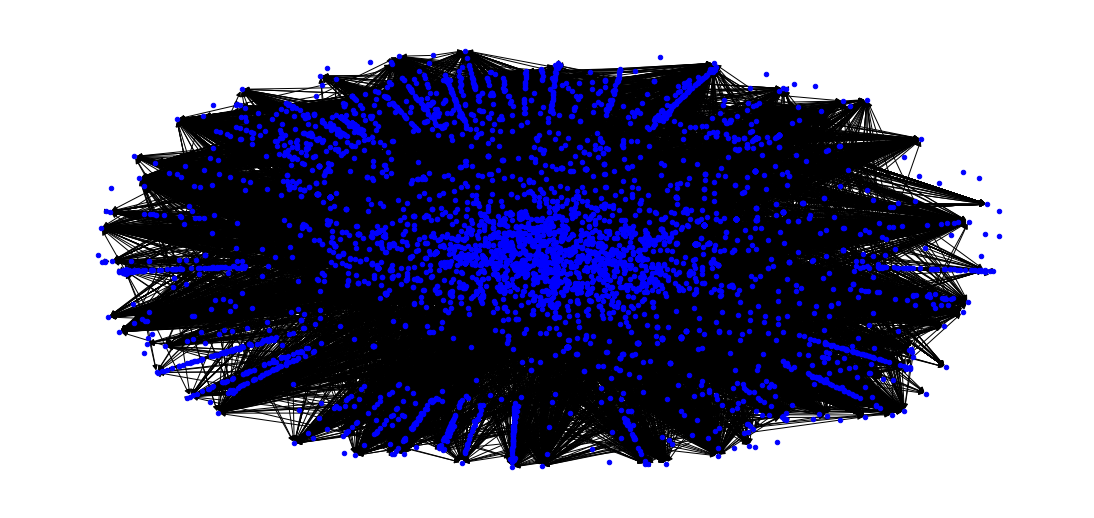

In [28]:
g = dataset[0]
options = {
    'node_color': 'blue',
    'node_size': 20,
    'width': 1,
}
G = dgl.to_networkx(g)
plt.figure(figsize=[15,7])
nx.draw(G, **options)

In [ ]:
graph_metadata = {}